In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
import pickle

warnings.filterwarnings("ignore")

In [15]:
path = "smote_Data_Lima.csv"
try:
    df = pd.read_excel(path)
except:
    df = pd.read_csv(path, sep=',')

print("="*60)
print("DATOS ORIGINALES")
print("="*60)
print(f"Dimensiones: {df.shape}")
print(f"\nDistribución de clases originales:")
print(df["Dx_anemia"].value_counts())
print(f"\nValores nulos por columna:")
print(df.isnull().sum())

# Remove unnecessary columns if they exist
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Create working copy
dataframe = df.copy()

DATOS ORIGINALES
Dimensiones: (46332, 8)

Distribución de clases originales:
Dx_anemia
0    11583
1    11583
2    11583
3    11583
Name: count, dtype: int64

Valores nulos por columna:
Sexo              0
Peso              0
Talla             0
Cred              0
Suplementacion    0
DistritoREN       0
Edad              0
Dx_anemia         0
dtype: int64


In [16]:
print(f"\nValores únicos en Sexo (antes de mapeo): {dataframe['Sexo'].unique()}")
print(f"Conteo de valores: \n{dataframe['Sexo'].value_counts()}")

# Clean and encode Sex
dataframe['Sexo'] = dataframe['Sexo'].astype(str).str.strip().str.upper()
dataframe['Sexo'] = dataframe['Sexo'].map({'F': 0, 'M': 1})

# Impute Sex if NaN after mapping
if dataframe['Sexo'].isnull().any():
    moda_values = dataframe['Sexo'].mode()
    if len(moda_values) > 0:
        dataframe['Sexo'] = dataframe['Sexo'].fillna(moda_values[0])
    else:
        print("⚠️ No hay moda para Sexo, usando 0 (F) por defecto")
        dataframe['Sexo'] = dataframe['Sexo'].fillna(0)
    print(f"Sexo imputado. Valores NaN restantes: {dataframe['Sexo'].isnull().sum()}")

# Encode District
le_distrito = LabelEncoder()
dataframe['DistritoREN'] = le_distrito.fit_transform(dataframe['DistritoREN'].astype(str))

# Identify numeric columns (except target)
numeric_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
if 'Dx_anemia' in numeric_cols:
    numeric_cols.remove('Dx_anemia')

print(f"\nColumnas numéricas a imputar: {numeric_cols}")



Valores únicos en Sexo (antes de mapeo): [0 1]
Conteo de valores: 
Sexo
0    28263
1    18069
Name: count, dtype: int64
⚠️ No hay moda para Sexo, usando 0 (F) por defecto
Sexo imputado. Valores NaN restantes: 0

Columnas numéricas a imputar: ['Sexo', 'Peso', 'Talla', 'Cred', 'Suplementacion', 'DistritoREN', 'Edad']


In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dataframe[numeric_cols] = imputer.fit_transform(dataframe[numeric_cols])

print(f"\nValores NaN después de imputación:")
print(dataframe.isnull().sum())

# Create derived features
dataframe['IMC'] = dataframe['Peso'] / ((dataframe['Talla']/100) ** 2)
dataframe['Peso_Talla_Ratio'] = dataframe['Peso'] / dataframe['Talla']

# Handle age columns - keep consistency
if 'EdadMeses' in dataframe.columns:
    dataframe['EdadAnios'] = dataframe['EdadMeses'] / 12
elif 'Edad' in dataframe.columns:
    dataframe['EdadMeses'] = dataframe['Edad'] * 12
    dataframe['EdadAnios'] = dataframe['Edad']

# Replace infinites
dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)


Valores NaN después de imputación:
Sexo              0
Peso              0
Talla             0
Cred              0
Suplementacion    0
DistritoREN       0
Edad              0
Dx_anemia         0
dtype: int64


In [9]:
if dataframe.isnull().any().any():
    print("\n⚠️ Se encontraron NaN en características derivadas. Imputando...")
    numeric_cols_all = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    if 'Dx_anemia' in numeric_cols_all:
        numeric_cols_all.remove('Dx_anemia')
    dataframe[numeric_cols_all] = imputer.fit_transform(dataframe[numeric_cols_all])

# Remove extreme outliers
for col in ['Peso', 'Talla', 'IMC']:
    if col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.01)
        Q3 = dataframe[col].quantile(0.99)
        dataframe = dataframe[(dataframe[col] >= Q1) & (dataframe[col] <= Q3)]

print(f"\n{'='*60}")
print(f"Datos después de limpieza: {dataframe.shape}")
print(f"Verificación final de NaN: {dataframe.isnull().sum().sum()} valores faltantes")
print(f"{'='*60}")


⚠️ Se encontraron NaN en características derivadas. Imputando...

Datos después de limpieza: (43959, 12)
Verificación final de NaN: 0 valores faltantes


In [18]:
X = dataframe.drop("Dx_anemia", axis=1)
y = dataframe["Dx_anemia"]

print(f"\nDistribución de clases antes de SMOTE:")
print(y.value_counts())

# Verify X has no NaN
print(f"\n{'='*60}")
print("VERIFICACIÓN FINAL ANTES DE SMOTE")
print(f"{'='*60}")
print(f"Valores NaN en X: {X.isnull().sum().sum()}")
print(f"Valores infinitos en X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Shape de X: {X.shape}")
print(f"Columnas de X: {X.columns.tolist()}")



Distribución de clases antes de SMOTE:
Dx_anemia
0    11583
1    11583
2    11583
3    11583
Name: count, dtype: int64

VERIFICACIÓN FINAL ANTES DE SMOTE
Valores NaN en X: 40
Valores infinitos en X: 0
Shape de X: (46332, 11)
Columnas de X: ['Sexo', 'Peso', 'Talla', 'Cred', 'Suplementacion', 'DistritoREN', 'Edad', 'IMC', 'Peso_Talla_Ratio', 'EdadMeses', 'EdadAnios']


In [19]:
feature_names = X.columns.tolist()

# Apply SMOTE if enough samples
min_samples = y.value_counts().min()
print(f"\nMínimo de muestras en clase minoritaria: {min_samples}")

if min_samples >= 2:
    k_neighbors = min(5, min_samples - 1)
    print(f"Aplicando SMOTE con k_neighbors={k_neighbors}")
    
    try:
        smote = SMOTE(sampling_strategy="not majority", random_state=42, k_neighbors=k_neighbors)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        print(f"\n✓ SMOTE aplicado exitosamente")
        print(f"Distribución después de SMOTE:")
        print(pd.Series(y_resampled).value_counts())
    except Exception as e:
        print(f"\n⚠️ Error al aplicar SMOTE: {e}")
        print("Continuando sin SMOTE...")
        X_resampled, y_resampled = X, y
else:
    print("\n⚠️ Muy pocas muestras para SMOTE. Usando class_weight='balanced' en el modelo.")
    X_resampled, y_resampled = X, y



Mínimo de muestras en clase minoritaria: 11583
Aplicando SMOTE con k_neighbors=5

⚠️ Error al aplicar SMOTE: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Continuando sin SMOTE...


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
)

print(f"\nTamaños de conjuntos:")
print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

# Hyperparameter search
print(f"\n{'='*60}")
print("BÚSQUEDA DE HIPERPARÁMETROS ÓPTIMOS")
print(f"{'='*60}")

param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced", "balanced_subsample"]
}

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Train
grid_search.fit(X_train, y_train)

print(f"\n{'='*60}")
print("MEJORES PARÁMETROS ENCONTRADOS:")
print(f"{'='*60}")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor score (F1-weighted) en validación cruzada: {grid_search.best_score_:.4f}")


Tamaños de conjuntos:
Train: 37065 | Test: 9267

BÚSQUEDA DE HIPERPARÁMETROS ÓPTIMOS
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

MEJORES PARÁMETROS ENCONTRADOS:
class_weight: balanced_subsample
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 300

Mejor score (F1-weighted) en validación cruzada: 0.8163


In [21]:
print(f"\n{'='*60}")
print("GUARDANDO MODELO ENTRENADO")
print(f"{'='*60}")
best_model = grid_search.best_estimator_


GUARDANDO MODELO ENTRENADO


In [22]:
model_filename = 'random_forest_anemia_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"✓ Modelo guardado exitosamente como: {model_filename}")

# También guardar el LabelEncoder del distrito para usarlo en predicciones
encoder_filename = 'distrito_label_encoder.pkl'
with open(encoder_filename, 'wb') as file:
    pickle.dump(le_distrito, file)

print(f"✓ Encoder de distrito guardado como: {encoder_filename}")

# Guardar los nombres de las características
feature_names_filename = 'feature_names.pkl'
with open(feature_names_filename, 'wb') as file:
    pickle.dump(feature_names, file)

print(f"✓ Nombres de características guardados como: {feature_names_filename}")

print(f"\nArchivos exportados:")
print(f"  1. {model_filename} - Modelo entrenado")
print(f"  2. {encoder_filename} - Codificador de distritos")
print(f"  3. {feature_names_filename} - Nombres de características")

✓ Modelo guardado exitosamente como: random_forest_anemia_model.pkl
✓ Encoder de distrito guardado como: distrito_label_encoder.pkl
✓ Nombres de características guardados como: feature_names.pkl

Archivos exportados:
  1. random_forest_anemia_model.pkl - Modelo entrenado
  2. distrito_label_encoder.pkl - Codificador de distritos
  3. feature_names.pkl - Nombres de características



REPORTE DE CLASIFICACIÓN EN TEST
              precision    recall  f1-score   support

           0       0.82      0.68      0.75      2317
           1       0.77      0.86      0.81      2316
           2       0.71      0.73      0.72      2317
           3       0.98      1.00      0.99      2317

    accuracy                           0.82      9267
   macro avg       0.82      0.82      0.82      9267
weighted avg       0.82      0.82      0.82      9267


Matriz de Confusión:
[[1585  263  466    3]
 [  82 1985  236   13]
 [ 261  346 1690   20]
 [   0    0    1 2316]]

ROC-AUC Score (multiclase, weighted): 0.9496
OOB Score: 0.8223

IMPORTANCIA DE CARACTERÍSTICAS
         feature  importance
     DistritoREN    0.205587
Peso_Talla_Ratio    0.180981
           Talla    0.133040
             IMC    0.123762
  Suplementacion    0.117250
            Peso    0.095704
            Cred    0.071464
       EdadMeses    0.025789
       EdadAnios    0.024797
            Edad    0.021626
 

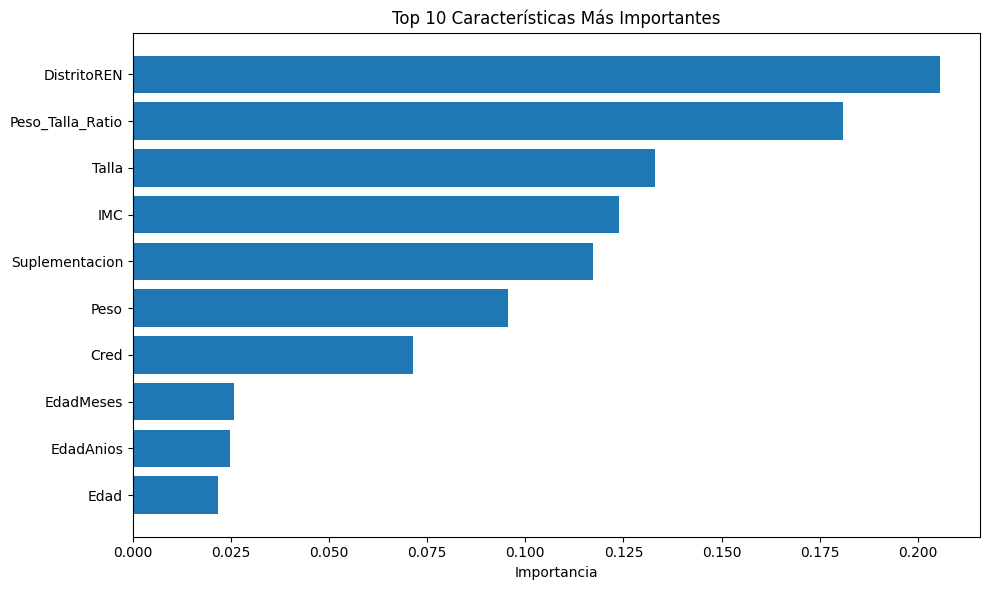

In [23]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print(f"\n{'='*60}")
print("REPORTE DE CLASIFICACIÓN EN TEST")
print(f"{'='*60}")
print(classification_report(y_test, y_pred))

print(f"\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# AUC
try:
    if len(np.unique(y)) == 2:
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        print(f"\nROC-AUC Score: {auc:.4f}")
    else:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"\nROC-AUC Score (multiclase, weighted): {auc:.4f}")
except:
    print("\nNo se pudo calcular ROC-AUC")

# OOB Score
if hasattr(best_model, 'oob_score_'):
    print(f"OOB Score: {best_model.oob_score_:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'='*60}")
print("IMPORTANCIA DE CARACTERÍSTICAS")
print(f"{'='*60}")
print(feature_importance.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importancia')
plt.title('Top 10 Características Más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
# Fixed prediction function
def predecir_anemia(sexo, edad_meses, peso, talla, cred, suplementacion, distrito):
    """
    Predice anemia para un nuevo paciente
    
    Parámetros:
    - sexo: 'F' o 'M'
    - edad_meses: edad en meses (int)
    - peso: peso en kg (float)
    - talla: talla en cm (float)
    - cred: control de crecimiento 0 o 1
    - suplementacion: 0 o 1
    - distrito: nombre del distrito (str)
    """
    
    # Create data dictionary matching training features
    datos = {
        'Sexo': 0 if sexo == 'F' else 1,
        'Peso': peso,
        'Talla': talla,
        'Cred': cred,
        'Suplementacion': suplementacion,
        'DistritoREN': 0,  # Will be transformed
        'Edad': edad_meses,  # Keep 'Edad' as in original data
        'IMC': peso / ((talla/100) ** 2),
        'Peso_Talla_Ratio': peso / talla,
        'EdadMeses': edad_meses,
        'EdadAnios': edad_meses / 12
    }
    
    # Create DataFrame with same columns as training data
    entrada = pd.DataFrame([datos])
    
    # Ensure columns match training data order
    entrada = entrada[feature_names]
    
    # Transform district
    try:
        entrada.loc[0, 'DistritoREN'] = le_distrito.transform([distrito])[0]
    except:
        print(f"⚠️ Distrito '{distrito}' no encontrado. Usando valor por defecto.")
        entrada.loc[0, 'DistritoREN'] = 0
    
    # Predict
    prediccion = best_model.predict(entrada)[0]
    probabilidades = best_model.predict_proba(entrada)[0]
    
    print(f"\n{'='*60}")
    print("RESULTADO DE PREDICCIÓN")
    print(f"{'='*60}")
    print(f"Diagnóstico predicho: Clase {prediccion}")
    print(f"\nProbabilidades por clase:")
    for clase, prob in zip(best_model.classes_, probabilidades):
        print(f"  Clase {clase}: {prob:.4f} ({prob*100:.2f}%)")
    
    # Interpretation
    interpretaciones = {
        0: "Sin anemia",
        1: "Anemia leve", 
        2: "Anemia moderada",
        3: "Anemia severa"
    }
    
    if prediccion in interpretaciones:
        print(f"\nInterpretación: {interpretaciones[prediccion]}")
    
    return prediccion, probabilidades



In [25]:
# Example prediction
print(f"\n{'='*60}")
print("EJEMPLO DE PREDICCIÓN")
print(f"{'='*60}")

ejemplo = predecir_anemia(
    sexo='F',
    edad_meses=32,
    peso=13.4,
    talla=89.0,
    cred=1,
    suplementacion=1,
    distrito='SAN JUAN DE MIRAFLORES'
)


EJEMPLO DE PREDICCIÓN
⚠️ Distrito 'SAN JUAN DE MIRAFLORES' no encontrado. Usando valor por defecto.

RESULTADO DE PREDICCIÓN
Diagnóstico predicho: Clase 0

Probabilidades por clase:
  Clase 0: 0.9299 (92.99%)
  Clase 1: 0.0200 (2.00%)
  Clase 2: 0.0501 (5.01%)
  Clase 3: 0.0000 (0.00%)

Interpretación: Sin anemia
